# Sign language project using Tensorflow 

## Goal

This notebook is to build a sign language classifier. One will be able to create own data, label it and train the classifier on specific signs. We will work with the American Sign Language (ASL) codes.


**Import libraries**

In [1]:
import uuid
import numpy as np
import os
import time
from pathlib import Path
import cv2 
import random
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [2]:
from PIL import Image
from io import BytesIO
import visualkeras
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import warnings

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

**Note:** One need to already collected data (in previous notebook) for the labels (in cell below).

### Label collected data

In [3]:
labels = ['hello', 'thanks', 'iloveyou', 'yes', 'no']

In [4]:
for label in labels:
    i = 0
    label_path = os.path.join('workspace', 'images', 'collectedimages', label)

    for filename in os.listdir(label_path):
        my_dest = label + str(i) + ".jpg"
        my_source = os.path.join(label_path, filename)
        my_dest = os.path.join(label_path, my_dest)
        # rename() function will rename all the files
        os.rename(my_source, my_dest)
        i += 1 

**Split data to train/test folder**

In [5]:
labels = ['hello', 'thanks', 'iloveyou', 'yes', 'no']
source_path = os.path.join('workspace', 'images')
        
paths = ['train', 'test']
for p in paths:
    for label in labels:
        path = os.path.join(source_path, p, label)
        if not os.path.exists(path):
            !mkdir {path}  

In [6]:
labels = ['hello', 'thanks', 'iloveyou', 'yes', 'no']
number_imgs = 10
test_size = int(np.ceil(0.25*number_imgs))
train_size = number_imgs - test_size

for label in labels:
    train_path = os.path.join('workspace', 'images', 'train', label)
    test_path = os.path.join( 'workspace', 'images', 'test', label)

    label_path = os.path.join('workspace', 'images', 'collectedimages', label)
 
    file_list = os.listdir(label_path)
    
    for file_name in random.sample(file_list, train_size):
        shutil.copy(os.path.join(label_path, file_name), train_path)
    
    for file_name in random.sample(file_list, test_size):
        shutil.copy(os.path.join(label_path, file_name), test_path)


In [7]:
train_path = os.path.join('workspace', 'images', 'train')
test_path = os.path.join( 'workspace', 'images', 'test')


In [8]:
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

# For getting next batch of images
imgs, labels = next(train_batches)

Found 35 images belonging to 5 classes.
Found 15 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

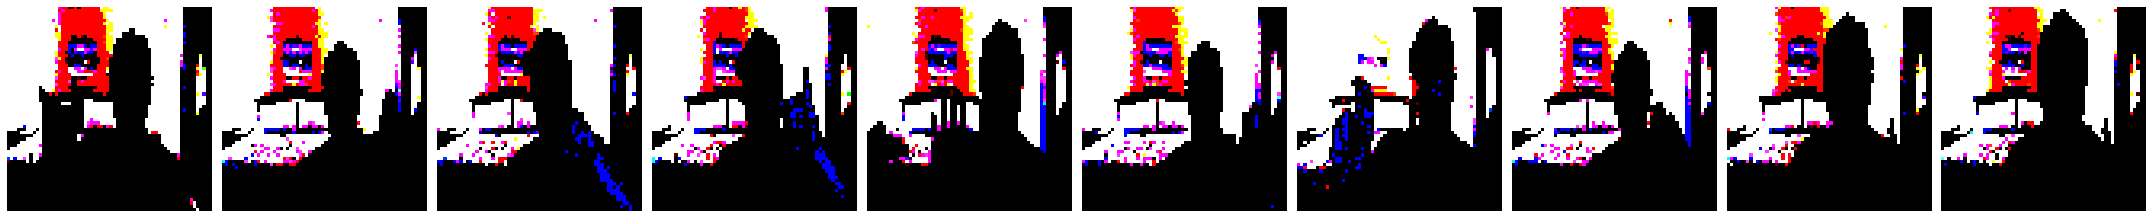

(10, 64, 64, 3)
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [9]:
# Plotting what the images and labels look like
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)

### Build model

In [10]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(5,activation ="softmax"))

In [11]:
visualkeras.layered_view(model, to_file='model.png').show()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [13]:
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


In [14]:
history = model.fit(train_batches, 
                    epochs=10, 
                    callbacks=[reduce_lr, early_stop],  
                    validation_data = test_batches) 

# For getting next batch of images
imgs, labels = next(train_batches) 


Epoch 1/10
4/4 [==============================] - 3s 480ms/step - loss: 14.7684 - accuracy: 0.2000 - val_loss: 14.8784 - val_accuracy: 0.2000
Epoch 2/10
4/4 [==============================] - 1s 308ms/step - loss: 7.0428 - accuracy: 0.1429 - val_loss: 1.9945 - val_accuracy: 0.2000
Epoch 3/10
4/4 [==============================] - 1s 308ms/step - loss: 1.9431 - accuracy: 0.1429 - val_loss: 1.4205 - val_accuracy: 0.4000
Epoch 4/10
4/4 [==============================] - 1s 267ms/step - loss: 1.4471 - accuracy: 0.3429 - val_loss: 1.5318 - val_accuracy: 0.2667
Epoch 5/10
4/4 [==============================] - 1s 257ms/step - loss: 1.4049 - accuracy: 0.3714 - val_loss: 1.3170 - val_accuracy: 0.4667
Epoch 6/10
4/4 [==============================] - 1s 260ms/step - loss: 1.2113 - accuracy: 0.6286 - val_loss: 1.2177 - val_accuracy: 0.5333
Epoch 7/10
4/4 [==============================] - 1s 262ms/step - loss: 1.1344 - accuracy: 0.6571 - val_loss: 1.1353 - val_accuracy: 0.5333
Epoch 8/10
4/4 [==

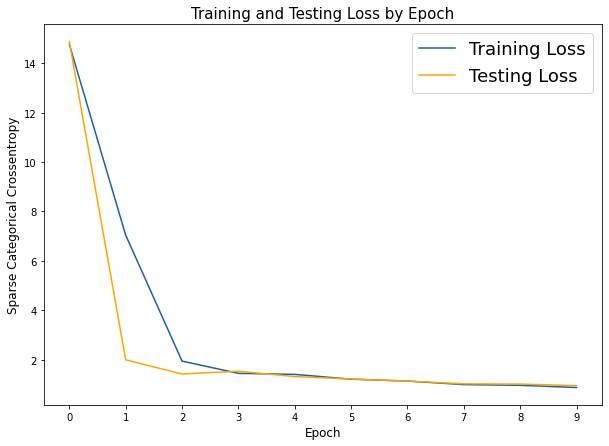

In [15]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(10, 7))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Sparse Categorical Crossentropy', fontsize=12)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [19]:
# model accuracy/loss scores for test set
imgs, labels = next(test_batches) 
scores = model.evaluate(imgs, labels, verbose=0)

print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

loss of 1.107082724571228; accuracy of 69.9999988079071%


In [20]:
model.save('best_model.h5')

print(history.history)

{'loss': [14.76836109161377, 7.042834758758545, 1.9431341886520386, 1.4470927715301514, 1.4048725366592407, 1.211343765258789, 1.1343799829483032, 0.9923788905143738, 0.9624720811843872, 0.8743274211883545], 'accuracy': [0.20000000298023224, 0.1428571492433548, 0.1428571492433548, 0.34285715222358704, 0.37142857909202576, 0.6285714507102966, 0.6571428775787354, 0.6285714507102966, 0.7428571581840515, 0.8285714387893677], 'val_loss': [14.878439903259277, 1.9945274591445923, 1.420470118522644, 1.5318031311035156, 1.3169822692871094, 1.217710256576538, 1.1353286504745483, 1.0229741334915161, 1.0128308534622192, 0.9492035508155823], 'val_accuracy': [0.20000000298023224, 0.20000000298023224, 0.4000000059604645, 0.2666666805744171, 0.46666666865348816, 0.5333333611488342, 0.5333333611488342, 0.6666666865348816, 0.6666666865348816, 0.800000011920929], 'lr': [0.001, 0.001, 0.001, 0.001, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005]}


In [21]:
imgs, labels = next(test_batches)

model = load_model(r"best_model.h5")

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

loss of 0.6334453821182251; accuracy of 100.0%


It is possible that, with such a small dataset, you don't get any predictions for a given class. This can be further improved adding more images from this class, or training your model with different lightings and positions.